In [1]:
import time
notebookstart= time.time()

In [60]:
import os
from typing import List, Tuple, Optional

import pandas as pd
import numpy as np

import cv2
#from PIL import Image
from pillow_heif import register_heif_opener
register_heif_opener() # for using Image.open for .heic without changes

import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
%matplotlib inline

In [4]:
DIR_DATA = os.path.join(os.getcwd(), 'data')
DIR_SUBM = os.path.join(os.getcwd(), 'subm')
DIR_SUBM_TRAIN = os.path.join(os.getcwd(), 'subm', 'train')
DIR_DATA_TRAIN = os.path.join(DIR_DATA, 'train')
DIR_DATA_TEST  = os.path.join(DIR_DATA, 'test')

In [6]:
train_df = pd.read_csv(os.path.join(DIR_SUBM_TRAIN, 'train_with_pred.csv'))
train_df.shape

(530, 11)

In [15]:
def open_img(inp_path: str) -> np.ndarray:
    
    if inp_path.endswith('.jpg'):
        ret_img = cv2.imread(inp_path)
    else:
        if pillow_heif.is_supported(inp_path):
            heif_file = pillow_heif.open_heif(inp_path, convert_hdr_to_8bit=False)
            #print("image mode:", heif_file.mode)
            #print("image data length:", len(heif_file.data))
            #print("image data stride:", heif_file.stride)
            if heif_file.has_alpha:
                heif_file.convert_to("BGRA;16")
            else:
                heif_file.convert_to("BGR;16")  # convert 10 bit image to RGB 16 bit.
            #print("image mode:", heif_file.mode)
            ret_img = np.asarray(heif_file)
    
    return ret_img

In [65]:
def plot_corrc(inp_df, inp_cols, targ_cols = ['distance']):
    f, ax = plt.subplots(1, 2, figsize=(24, 8))
    sns.heatmap(inp_df[inp_cols + targ_cols].corr(),
    #sns.heatmap(inp_df.query('c2 == 0')[inp_cols + targ_cols].corr(), \n",
                annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black', ax = ax[0])
    sns.heatmap(inp_df[inp_cols + targ_cols].corr(method = 'spearman'),
    #sns.heatmap(inp_df.query('c2 == 1')[inp_cols + targ_cols].corr(), \n",
                annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black', ax = ax[1])
#    sns.heatmap(inp_df.query('c2 == 0')[inp_cols + targ_cols].corr(method = 'spearman'), \n",
#                annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black', ax = ax[1, 0])\n",
#    sns.heatmap(inp_df.query('c2 == 1')[inp_cols + targ_cols].corr(method = 'spearman'), \n",
#                annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black', ax = ax[1, 1])\n",
    if 'distrib_brdr' in inp_df.columns:
        sns.pairplot(inp_df[inp_cols + targ_cols + ['distrib_brdr']], height = 16,
                     hue = 'distrib_brdr', #palette = {\"A\": \"C0\", \"B\": \"C1\"}\n",
                     #markers = ['x', 'o']\n",
                    )
    else:
        sns.pairplot(inp_df[inp_cols + targ_cols], height = 16,
                    )
   

Рассчитаем и помотрим на ошибки

In [33]:
train_df['err'] = train_df.distance - train_df.pred
train_df['err_upd'] = train_df.err.apply(lambda x: abs(x))

<AxesSubplot:>

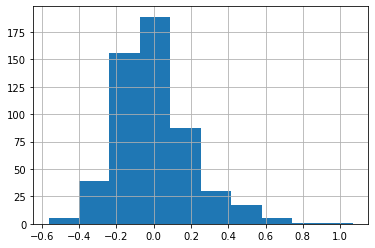

In [45]:
train_df.err.hist()

<AxesSubplot:>

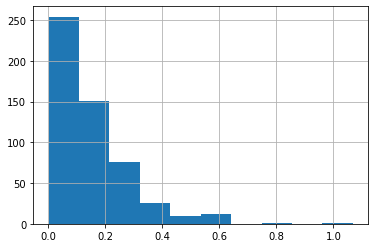

In [46]:
train_df.err_upd.hist()

In [49]:
train_df.err.nsmallest(5)

14    -0.562760
483   -0.442756
98    -0.430125
508   -0.423282
108   -0.404371
Name: err, dtype: float64

In [50]:
train_df.err.nlargest(5)

507    1.068092
16     0.809791
513    0.640836
30     0.631024
56     0.627965
Name: err, dtype: float64

In [37]:
train_df.sort_values(by='err_upd', ascending = False, inplace = True)

In [47]:
train_df.head(20)

,image_name,distance,x_min,y_min,x_max,y_max,conf,class,h,w,pred,err,err_upd
507,img_2903.jpg,4.33,1392.591064,1183.050781,2279.875977,1880.717041,0.933878,2.0,697.666260,887.284912,3.261908,1.068092,1.068092
16,img_1623.jpg,5.56,1606.542480,1277.125488,2219.218994,1807.470337,0.894042,2.0,530.344849,612.676514,4.750209,0.809791,0.809791
513,img_2913.jpg,6.61,1659.580811,1239.323730,2132.031494,1629.814209,0.915593,2.0,390.490479,472.450684,5.969164,0.640836,0.640836
30,img_1650.jpg,4.69,1595.788574,1164.596313,2269.871094,1735.376343,0.905048,2.0,570.780029,674.082520,4.058976,0.631024,0.631024
56,img_1707.jpg,5.88,1636.430298,1291.904053,2145.447266,1727.222534,0.913924,2.0,435.318481,509.016968,5.252035,0.627965,0.627965
63,img_1715.jpg,4.30,1574.948975,1257.245605,2310.006104,1837.639038,0.933454,2.0,580.393433,735.057129,3.674662,0.625338,0.625338
61,img_1713.jpg,3.96,1600.428955,1105.802490,2383.656006,1739.076172,0.926868,2.0,633.273682,783.227051,3.380803,0.579197,0.579197
58,img_1709.jpg,7.17,1675.892456,1274.072876,2102.822021,1642.652222,0.921770,2.0,368.579346,426.929565,6.594045,0.575955,0.575955
15,img_1621.jpg,7.37,1479.507080,1121.258911,2624.041016,2121.085449,0.887677,2.0,999.826538,1144.533936,6.799968,0.570032,0.570032
22,img_1635.jpg,3.11,1433.187256,1023.633484,2514.844971,1941.821655,0.929678,2.0,918.188171,1081.657715,2.545228,0.564772,0.564772


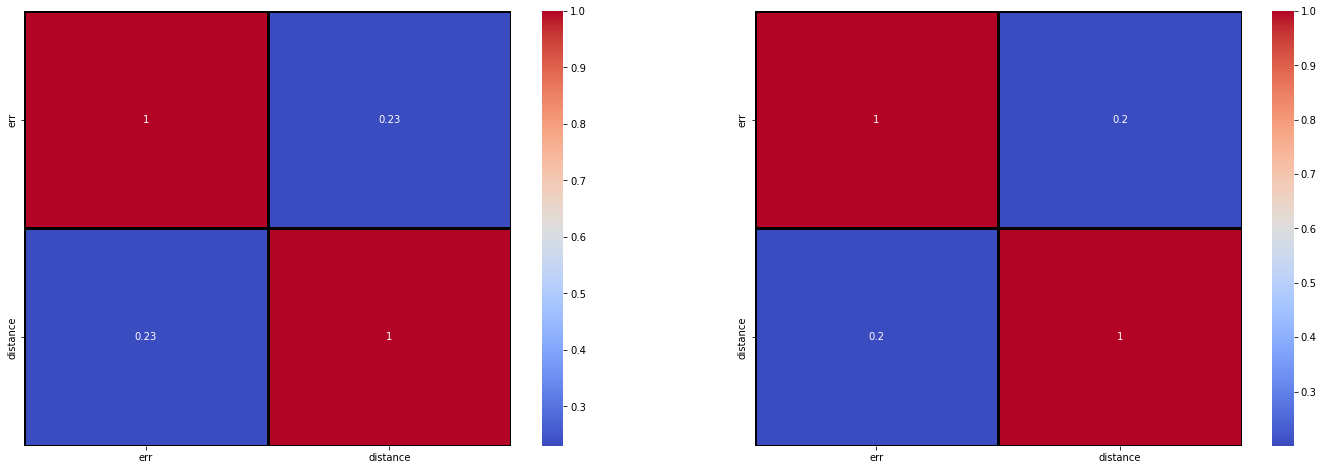

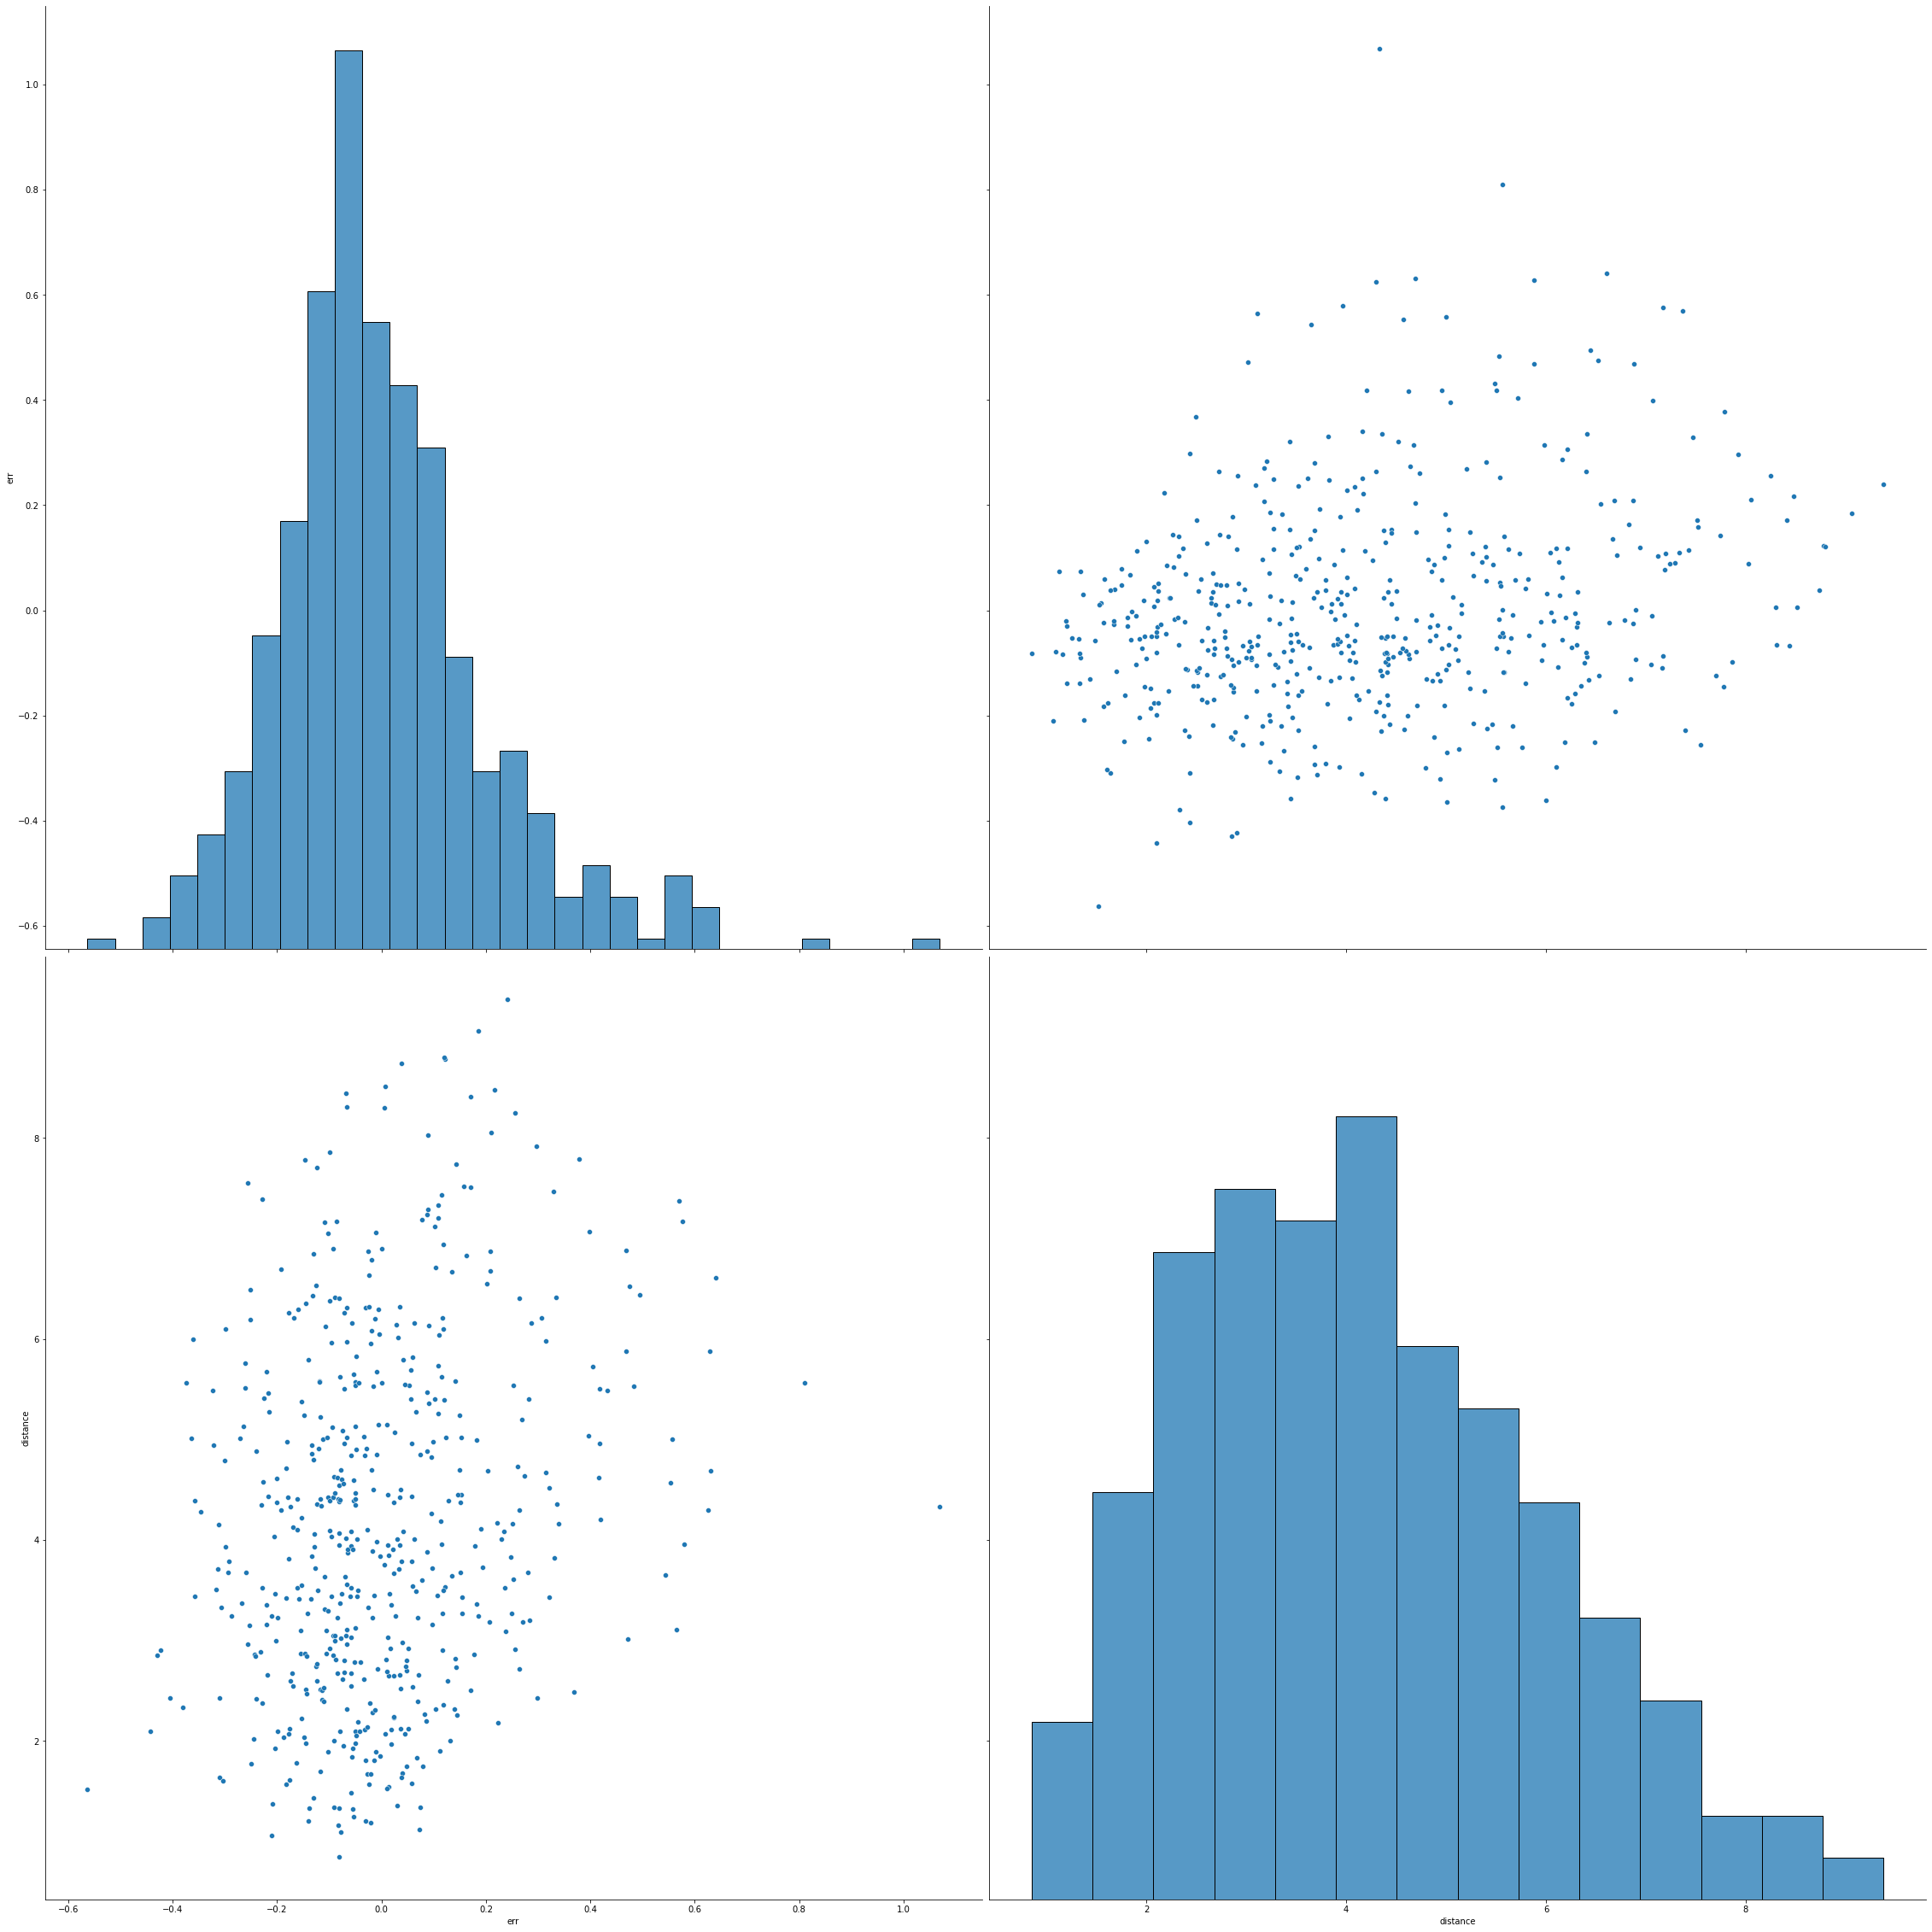

In [66]:
plot_corrc(train_df, ['err'])

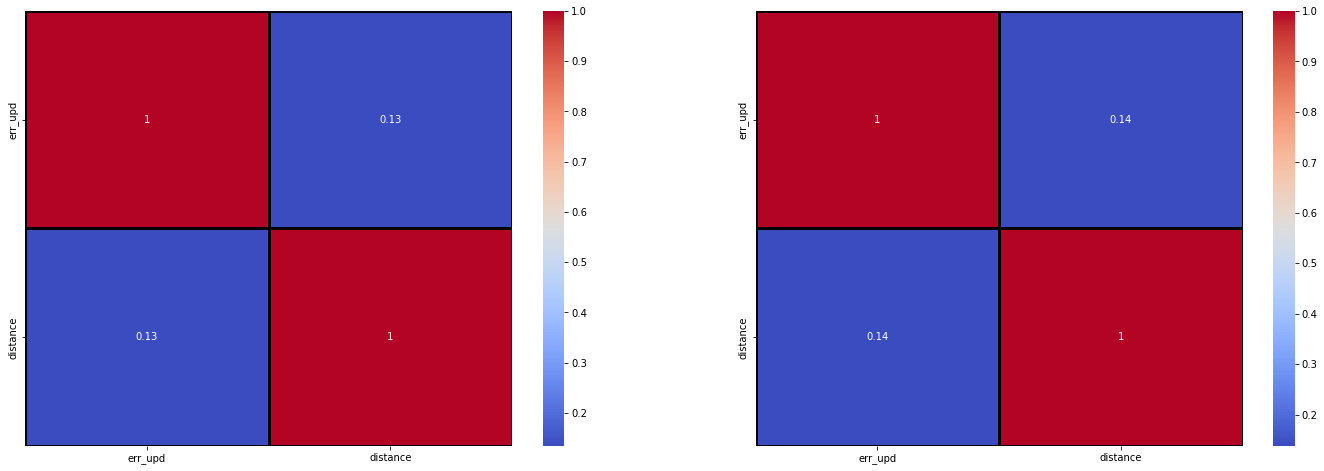

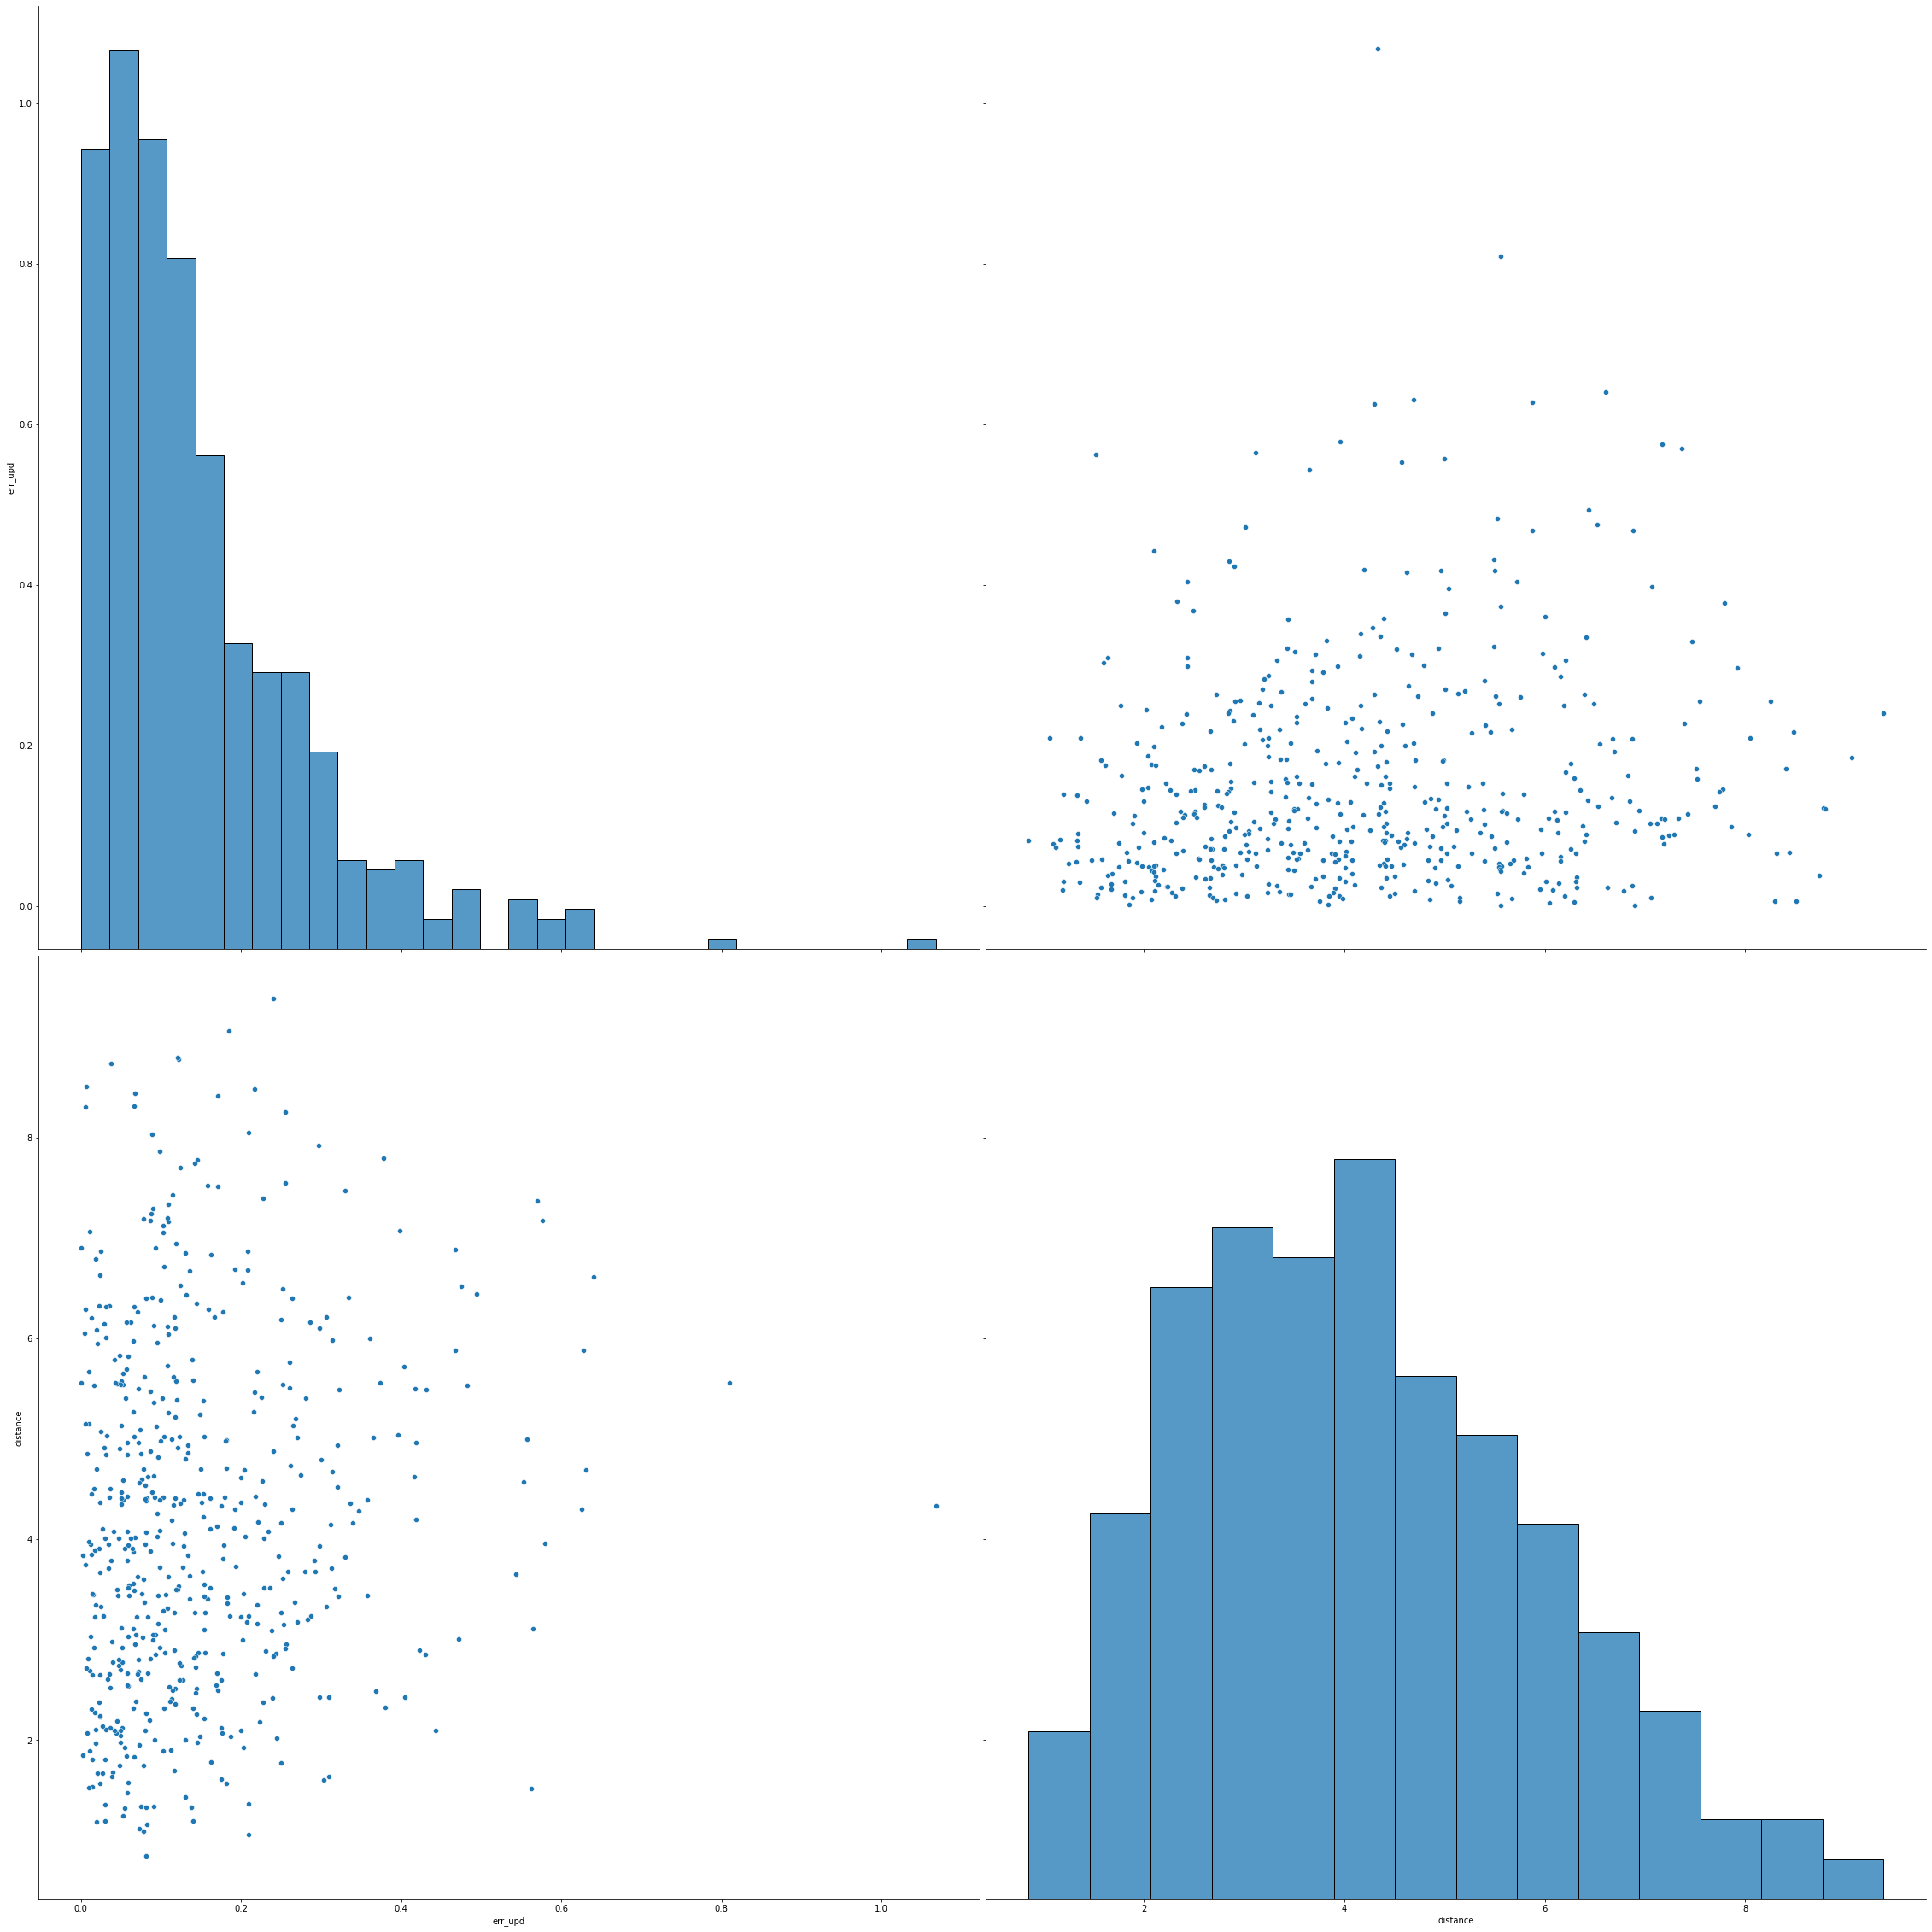

In [62]:
#plot_corrc(train_df, ['err_upd'])

Посмотрим на кадры с наибольней (по модулю) ошибкой

In [56]:
for el in train_df.index[:5]:
    name, x_min, y_min, x_max, y_max, dist, pred, err = train_df.loc[el, ['image_name', 'x_min', 'y_min', 'x_max', 'y_max', 'distance', 'pred', 'err']].values
    img = open_img(os.path.join(DIR_DATA_TRAIN, name))

    cv2.rectangle(img, 
                  (int(x_min), int(y_min)), 
                  (int(x_max), int(y_max)),
                  (255, 0, 0), 
                  6,
                  #cv2.FILLED
                 )


    img = cv2.resize(img, [252*4, 252*3])

    cv2.imshow('bir error', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()